In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, floor
import random
import csv

np.random.seed(0)

## Linear Ridge Regression in Multiple Dimension [Medium]

In [2]:
# utilities for creating a dataset

### data structure to represent dataset
class Dataset:
    def __init__(self, x: np.ndarray, y: np.ndarray, n = None):
        # todo: assertion to verify the dimension of x and y
        self.__x = x
        self.__y = y
        self.__n = n if n else len(x)
        
    def split(self, split_fraction):
        # splits the dataset into two parts
        X1, Y1 = [], []
        X2, Y2 = [], []
        for x, y in self:
            if (random.random() < split_fraction):
                X1.append(x)
                Y1.append(y)
            else:
                X2.append(x)
                Y2.append(y)
        d1 = Dataset(np.array(X1), np.array(Y1))
        d2 = Dataset(np.array(X2), np.array(Y2))
        return d1, d2
    
    def k_split(self, k):
        if (k < 2):
            raise AssertionError('Cannot split dataset into 1')
            
        batch_size = ceil(self.__n / k)
        x, y = list(self.__x), list(self.__y)
        
        for i in range(k):
            x_temp = x[:batch_size*i] + x[batch_size*(i+1):]
            y_temp = y[:batch_size*i] + y[batch_size*(i+1):]
            train = Dataset(np.array(x_temp), np.array(y_temp))
            
            x_temp = x[batch_size*i : batch_size*(i+1)]
            y_temp = y[batch_size*i : batch_size*(i+1)]
            validation = Dataset(np.array(x_temp), np.array(y_temp))
            
            yield (train, validation)
    
    @property
    def x(self):
        return self.__x

    @property
    def y(self):
        return self.__y
    
    @x.setter
    def x(self, value):
        self.__x = value
        
    @y.setter
    def y(self, value):
        self.__y = value
        
    def __getitem__(self, index: int):
        #todo: assertion to verify out of bounds
        return self.__x[index], self.__y[index]
    
    def __setitem__(self, index: int, x_: np.ndarray, y_: np.ndarray):
        # todo: assertion to verify out of bounds
        self.__x[index] = x_
        self.__y[index] = y_
    
    def __len__(self):
        return self.__n
    
    def __del__(self):
        del(self.__x)
        del(self.__y)
        del(self.__n)
    
    def __iter__(self):
        self.__index = 0
        return self
    
    def __next__(self):
        if (self.__index < self.__n):
            self.__index += 1
            return self[self.__index - 1]
        raise StopIteration

In [3]:
# read data and create a dataset out of it
# NOTE: The only label field must be the last column

def read_raw(path: str, exceptions = set([])):
    # read raw data from csv
    # convert str to float
    # for every field possible
    file = open(path, "r")
    raw_data = csv.reader(file, delimiter = ',')
    
    data = []
    for row in raw_data:
        for (i, value) in enumerate(row):
            try:
                if i not in exceptions:
                    row[i] = float(value)
            except:
                pass
        data.append(row)
    file.close()
    
    return data

def get_field_info(data):
    num_rows, num_cols = len(data), len(data[0])
    
    # extract information about numeric and non-numeric fields
    non_numeric_fields = {}
    numeric_fields = set([])
    
    for index in range(num_cols-1):
        if type(data[0][index]) == float:
            numeric_fields.add(index)
            continue
        # for each non-numeric field, we maintain information about number
        # and types of different values possible for that field
        non_numeric_fields[index] = {'count': -1, 'values': {}}
    
    for row in data:
        for index, field in non_numeric_fields.items():
            value = row[index]
            if (value not in field['values']):
                field['count'] += 1
                field['values'][value] = field['count']
    
    return non_numeric_fields, numeric_fields

def construct_design_matrix(data, non_numeric_fields, numeric_fields):
    num_rows, num_cols = len(data), len(data[0])
    
    # constructing desired design matrix and label vector.
    # we encode non-numeric values using one-hot encoding.
    # also we add "1" to every feature vector to accomodate constant
    
    # however, after one hot encoding, we eliminate a column
    # for each original non-numeric field to reduce correlation
    # between newly formed fields
    
    X, Y = [], []
    
    for i, row in enumerate(data):
        x = []
        Y.append(row[num_cols-1])
        for index in range(num_cols - 1):
            
            value = row[index]
            
            # append numeric feature as it is
            if (index in numeric_fields):
                x.append(row[index])
                continue
                
            # encode non-numeric feature and append
            field = non_numeric_fields[index]
            one_hot_encoded = [0]*field['count']
            pos = field['values'][value]
            if (pos): one_hot_encoded[pos-1] = 1
            x.extend(one_hot_encoded)
        
        X.append(x)
    
    return np.array(X), np.array(Y)

def get_dataset(path: str, hasHeader = True, exceptions = set([])):
    
    data = read_raw(path, exceptions)
    
    # remove first row if it is a header
    if (hasHeader):
        data = data[1:]
    
    # check if there is data
    if (not data):
        raise IndexError('No data in the given file')
    
    # extract information about numeric and non-numeric fields
    non_numeric_fields, numeric_fields = get_field_info(data)
    
    X, Y = construct_design_matrix(data, non_numeric_fields, numeric_fields)
    
    return Dataset(X, Y)

In [4]:
# setting up path of .csv file
path = 'dataset/insurance.csv'

exceptions = [3] # specify columns which are numerical but you want them to be hot encoded

dataset = get_dataset(path, exceptions = set(exceptions))

#### Feature Normalization

In [5]:
# normalize a 2-d matrix

def get_mean_variance(matrix):
    num_rows, num_cols = matrix.shape
    mean = np.sum(matrix, axis=0, keepdims=True) / num_rows
    variance = (np.sum((matrix - mean) ** 2, axis=0, keepdims=True) / (num_rows))
    return mean, variance

def normalize(matrix, mean, variance):
    num_rows, num_cols = matrix.shape
    std = variance ** 0.5
    for i in range(num_cols):
        if (std[0][i] == 0):
            std[0][i] = 1
    return (matrix - mean) / std

dataset.x = normalize(dataset.x, *get_mean_variance(dataset.x))
mean, variance = get_mean_variance(dataset.x)
print(f'Verifying Mean and Variance for Normalized Data (for each feature):\nMean\t\t{np.around(mean, 4)}\nVariance\t{np.around(variance, 4)}')

Verifying Mean and Variance for Normalized Data (for each feature):
Mean		[[-0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.]]
Variance	[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


#### Partition dataset into (training and validation) and test set

In [6]:
# adding a constant 1 to accomodate bias term
dataset.x = np.c_[[1]*len(dataset.x), dataset.x]

In [7]:
test_set, train_validation_set = dataset.split(0.2)

#### Ridge Regression

In [8]:
# gradient descent for ridge regression
# and k_cross_validation

### setting up hyperparameters
num_iterations = int(1e4)
learning_rate = 1e-3

def ridgereg(X, Y, lamda, num_iterations = num_iterations):
    n = len(Y)
    w = np.random.rand(X.shape[1])
    
    # gradient descent updates
    for iteration in range(1, num_iterations+1):
        y = predridge(X, w)
        p2_error = lamda*w
        p2_error[0] = 0
        w -= learning_rate * ((X.T @ ((X/n)@w - Y/n)) + p2_error/n)
        
        if (iteration % 10000 == 0):
            delta = predridge(X, w) - Y
            loss = (np.sum(delta**2))/n
            print(f'Training error on {iteration}th iteration  ==> {loss}\t\t', end = '\r')
        
    print()
    
    y = predridge(X, w)
    train_error = np.sum((Y - y) ** 2)/n

    return w, train_error

def predridge(X, w):
    return (X@w)


def k_cross_validation(dataset, k, lamda):
    kcv_datasets = dataset.k_split(k)
    
    validation_errors = []
    train_errors = []
    
    for train, validation in kcv_datasets:
        w, train_error = ridgereg(train.x, train.y, lamda)
        y = predridge(validation.x, w)
        validation_error = (np.sum((validation.y - y) ** 2)/len(y))
        print(f'Validation error ==> {validation_error}')
        validation_errors.append(validation_error)
        train_errors.append(train_error)
    
    return train_errors, validation_errors

In [9]:
# for multiple lambda values, we calculate and plot
# validation error for each of the k-sets

### setting up parameters
k = 10
lambdas = [1e-1, 1, 10, 15, 1e2]

results = {}

for lamda in lambdas:
    print(f'lambda: {lamda}')
    results[lamda] = k_cross_validation(dataset, k, lamda)
    print(f'\nAverage Validation Error: {sum(results[lamda][1])/len(results[lamda][1])}')
    print('=======\n')

lambda: 0.1
Training error on 10000th iteration  ==> 36439042.95868278		
Validation error ==> 35894870.67030574
Training error on 10000th iteration  ==> 36110848.99757947		
Validation error ==> 38740534.09945913
Training error on 10000th iteration  ==> 36333068.46254714		
Validation error ==> 36717717.35451432
Training error on 10000th iteration  ==> 36023569.097139545		
Validation error ==> 39780763.98171125
Training error on 10000th iteration  ==> 36140189.67927468		
Validation error ==> 38832507.3412141
Training error on 10000th iteration  ==> 37516457.242845275		
Validation error ==> 26183994.789016247
Training error on 10000th iteration  ==> 37030990.05076845		
Validation error ==> 30404857.021973837
Training error on 10000th iteration  ==> 35092288.68572805		
Validation error ==> 48321354.60540481
Training error on 10000th iteration  ==> 36663291.646843165		
Validation error ==> 33985722.14222702
Training error on 10000th iteration  ==> 35805570.97335432		
Validation error ==> 41

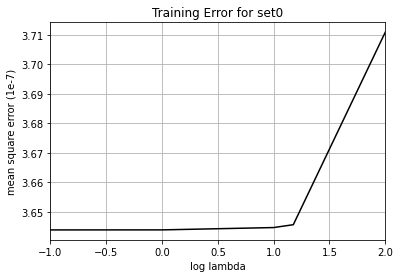

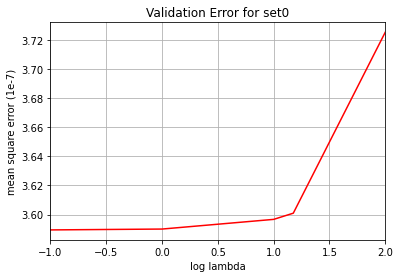

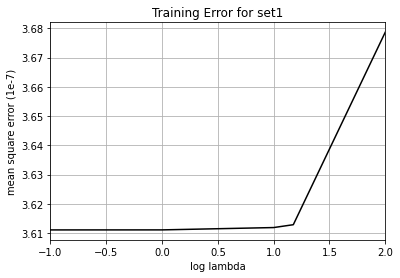

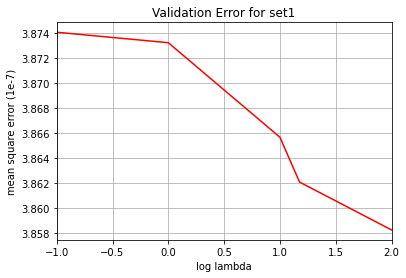

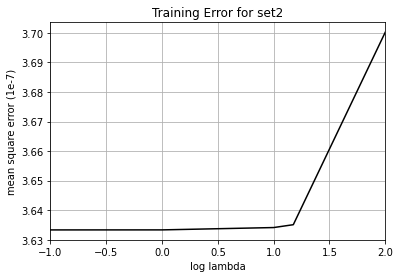

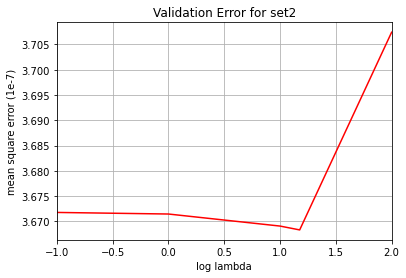

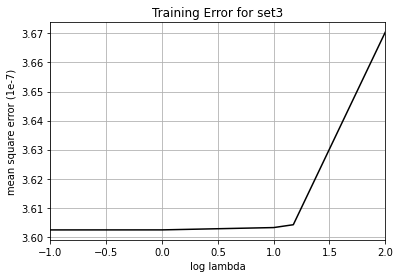

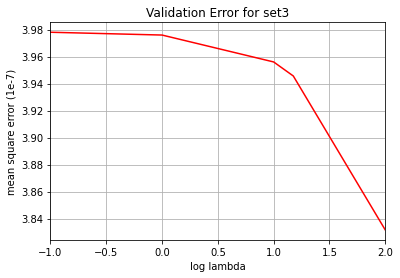

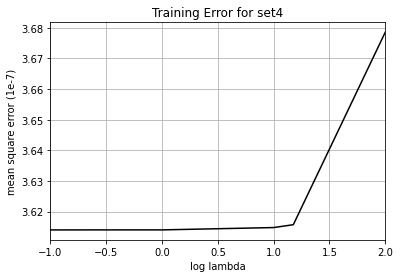

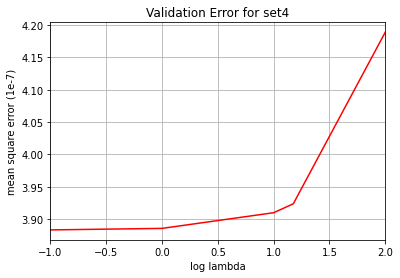

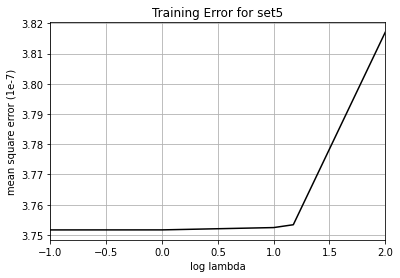

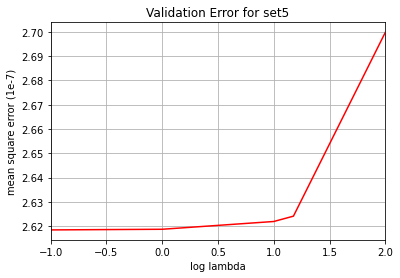

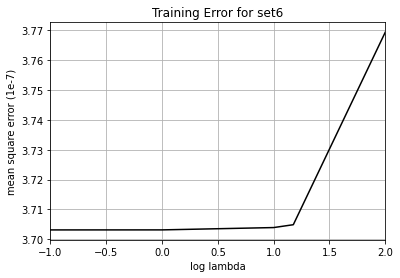

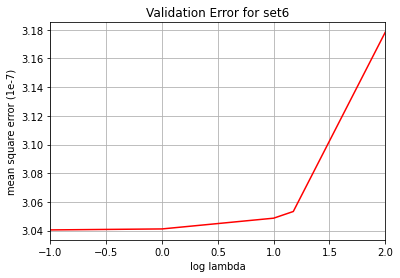

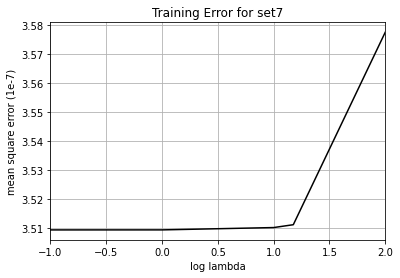

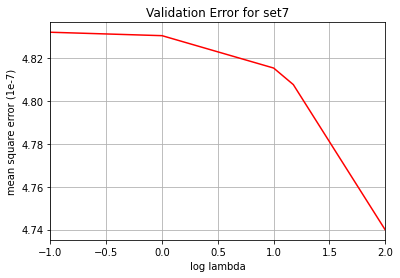

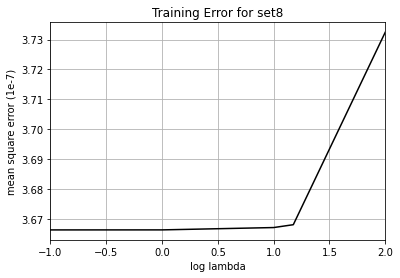

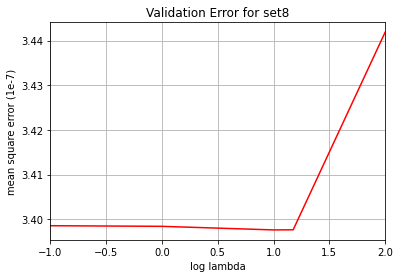

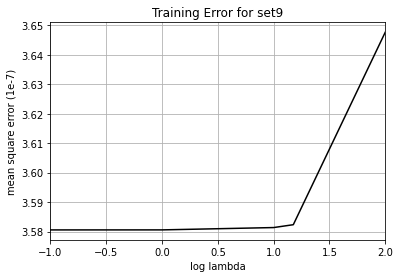

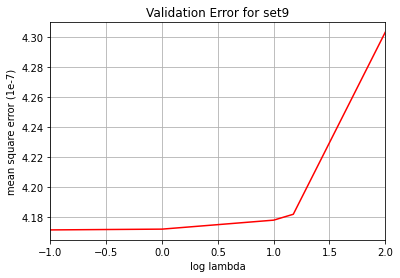

Training error on 10000th iteration  ==> 36732107.59617438		
Training error on 10000th iteration  ==> 36732226.65280701		
Training error on 10000th iteration  ==> 36741895.86991205		
Training error on 10000th iteration  ==> 36753743.71255622		
Training error on 10000th iteration  ==> 37544861.31397557		


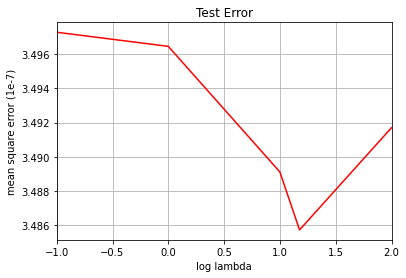

In [19]:
### plotting results
def plot(x, y, color, label):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y, color = color)
    plt.title(label)
    plt.xlabel('log lambda')
    plt.ylabel('mean square error (1e-7)')
    plt.xlim(min(x), max(x))
    plt.grid(True)
    plt.show()
    
def get_log(x):
    try:
        ans = np.log10(x)
    except:
        ans = float('-inf')
    return ans

log_lambda = [get_log(i) for i in lambdas]
    
for i in range(k):
    training_errors = []
    validation_errors = []
    for lamda in lambdas:
        t_error, v_error = results[lamda]
        training_errors.append(t_error[i])
        validation_errors.append(v_error[i])
        
    plot(log_lambda, list(map(lambda x: x/1e7, training_errors)), 'black', f'Training Error for set{i}')
    plot(log_lambda, list(map(lambda x: x/1e7, validation_errors)), 'red', f'Validation Error for set{i}')

print('==========')
    
test_errors = []    

for lamda in lambdas:
    X, Y = test_set.x, test_set.y
    w, _ = ridgereg(train_validation_set.x, train_validation_set.y, lamda)
    y = predridge(X, w)
    test_error = (np.sum((y-Y)**2))/len(y)

    test_errors.append(test_error)

plot(log_lambda, list(map(lambda x: x/1e7, test_errors)), 'red', 'Test Error')